# Toxic Comment Classification with Bi-LSTM with Attention and GloVe Embeddings
---

### The Problem This Code Solves
- Before diving into the technical details, it's important to understand what problem this code addresses. It solves multi-label text classification (predicting 6 different categories or labels simultaneously) where the dataset likely suffers from class imbalance, as we saw before.

---

### Import libraries

In [3]:
# !pip install --upgrade pip
# !pip install contractions bs4 nltk beautifulsoup4

import sys
sys.path.append('/kaggle/input/code-utility')
from clean_utilities import TextCleaner
import model_utilities as mu
# Import necessary libraries
import pandas as pd
import numpy as np

import tensorflow as tf

import warnings
warnings.filterwarnings('ignore')

# Set random seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 22.4 MB/s eta 0:00:0000:010:01
  Attempting uninstall: pip
    Found existing installation: pip 24.1.2
    Uninstalling pip-24.1.2:
      Successfully uninstalled pip-24.1.2
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5/5 [contractions] [contractions]


[nltk_data] Downloading package punkt_tab to /usr/share/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
2025-05-26 16:46:17.849377: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1748277978.037947      35 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1748277978.097883      35 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


### 1- Load the Data

In [4]:
# Load train data
df_train = pd.read_csv('/kaggle/input/jigsaw-toxic-comment-classification-challenge/train.csv.zip')

# Load test data without labels
df_test = pd.read_csv('/kaggle/input/jigsaw-toxic-comment-classification-challenge/test.csv.zip')

# Load the test labels 
df_test_label = pd.read_csv('/kaggle/input/jigsaw-toxic-comment-classification-challenge/test_labels.csv.zip')


### 2- Prepare the Validation Data

In [5]:
# Remove rows where ANY column (except 'id') has a negative value
df_test_label = df_test_label[~(df_test_label.drop(columns='id') < 0).any(axis=1)]

# Get the index of kept rows in `y_train`
kept_indices = df_test_label.index

# Filter `X_train` to keep only matching indices
df_test1 = df_test.loc[kept_indices]

# concatenation the comment_text and the labels
df_val = pd.concat([df_test1['comment_text'], df_test_label], axis=1)

# Reorder the columns
df_val = df_val[['id', 'comment_text', 'toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']]
df_val

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
5,0001ea8717f6de06,Thank you for understanding. I think very high...,0,0,0,0,0,0
7,000247e83dcc1211,:Dear god this site is horrible.,0,0,0,0,0,0
11,0002f87b16116a7f,"""::: Somebody will invariably try to add Relig...",0,0,0,0,0,0
13,0003e1cccfd5a40a,""" \n\n It says it right there that it IS a typ...",0,0,0,0,0,0
14,00059ace3e3e9a53,""" \n\n == Before adding a new product to the l...",0,0,0,0,0,0
...,...,...,...,...,...,...,...,...
153150,fff8f64043129fa2,":Jerome, I see you never got around to this…! ...",0,0,0,0,0,0
153151,fff9d70fe0722906,==Lucky bastard== \n http://wikimediafoundatio...,0,0,0,0,0,0
153154,fffa8a11c4378854,==shame on you all!!!== \n\n You want to speak...,0,0,0,0,0,0
153155,fffac2a094c8e0e2,MEL GIBSON IS A NAZI BITCH WHO MAKES SHITTY MO...,1,0,1,0,1,0


### 3- Cleaning Process Includes:
- Remove HTML and XML tags
- Remove non-ASCII characters
- Fix contractions
- Replace entities with placeholders
- Convert to lowercase
- Typos, slang, Acronyms, Some common abbreviations
- Remove punctuation
- Remove numbers
- Remove extra whitespace
- Tokenize
- Remove stop words

---

#### 3.1 Create cleaner instance

In [6]:
# Create cleaner instance
cleaner = TextCleaner()

#### 3.2 Display a sample before and after cleaning

In [7]:
# Example with a single comment
sample_comment = df_train['comment_text'].iloc[0]  # Get the 0th comment which contains toxic content
print("Original toxic comment:")
print(sample_comment)
print("\nCleaned toxic comment:")
print(cleaner.clean_text(sample_comment))

Original toxic comment:
Explanation
Why the edits made under my username Hardcore Metallica Fan were reverted? They weren't vandalisms, just closure on some GAs after I voted at New York Dolls FAC. And please don't remove the template from the talk page since I'm retired now.89.205.38.27

Cleaned toxic comment:
explanation edits made username hardcore metallica fan reverted vandalisms closure gas voted new york dolls fac please remove template talk page since retired


#### 3.3 Clean Train Data

In [8]:
# Process the train dataset sequentially in batches
cleaned_comments = cleaner.process_dataframe(df_train, 'comment_text', batch_size=10000)

# Add cleaned comments back to dataframe
df_train['cleaned_comment'] = cleaned_comments

Processed 10000/159571 texts (6.3%)
Processed 30000/159571 texts (18.8%)
Processed 50000/159571 texts (31.3%)
Processed 70000/159571 texts (43.9%)
Processed 90000/159571 texts (56.4%)
Processed 110000/159571 texts (68.9%)
Processed 130000/159571 texts (81.5%)
Processed 150000/159571 texts (94.0%)


#### 3.4 Clean Validation Data

In [9]:
# Process the val dataset sequentially in batches
cleaned_comments = cleaner.process_dataframe(df_val, 'comment_text', batch_size=10000)

# Add cleaned comments back to dataframe
df_val['cleaned_comment'] = cleaned_comments

Processed 10000/63978 texts (15.6%)
Processed 30000/63978 texts (46.9%)
Processed 50000/63978 texts (78.2%)
Processed 63978/63978 texts (100.0%)


#### 3.5 Clean Test Data

In [10]:
# Process the test dataset sequentially in batches
cleaned_comments = cleaner.process_dataframe(df_test, 'comment_text', batch_size=10000)

# Add cleaned comments back to dataframe
df_test['cleaned_comment'] = cleaned_comments

Processed 10000/153164 texts (6.5%)
Processed 30000/153164 texts (19.6%)
Processed 50000/153164 texts (32.6%)
Processed 70000/153164 texts (45.7%)
Processed 90000/153164 texts (58.8%)
Processed 110000/153164 texts (71.8%)
Processed 130000/153164 texts (84.9%)
Processed 150000/153164 texts (97.9%)


#### 3.6 Display a sample before and after cleaning

In [11]:
# Show examples after cleaning
print("\nExamples of cleaned comments:")
print(f"Original: {df_train['comment_text'].iloc[0]}...")
print(f"Cleaned: {df_train['cleaned_comment'].iloc[0]}...")


Examples of cleaned comments:
Original: Explanation
Why the edits made under my username Hardcore Metallica Fan were reverted? They weren't vandalisms, just closure on some GAs after I voted at New York Dolls FAC. And please don't remove the template from the talk page since I'm retired now.89.205.38.27...
Cleaned: explanation edits made username hardcore metallica fan reverted vandalisms closure gas voted new york dolls fac please remove template talk page since retired...


### 4- Load and preprocess data:
- Remove comment_text column from train and val data
- Split training and validation data into X_train, y_train, X_val, y_val
- **Tokenization process:**<small>
    - Create Tokenizer object with max features and Unknown token
    - Fit Tokenizer on training data, transform text to sequence of tokens
    - Transform validation data into sequence of tokens (unique numbers)
    - Pad and truncate train, val sequences with max sequence length based on 95th percentile</small>

---

In [12]:
# Load and preprocess the data
processed_data = mu.load_and_preprocess_data(df_train, df_val, max_features=50000)

Loading and preprocessing data...
Train set shape: (159571, 114)
Test set shape: (63978, 114)


### 5- GloVe Embeddings Loader

- Purpose: <small>Creates an embedding matrix using **pre-trained GloVe word vectors** (6B parameter) for use in neural networks.</small>

##### Parameters<small>
- `word_index`: Dictionary mapping words to numerical indices (from tokenizer)
- `embedding_dim`: Vector dimension (100, 200, 300) - must match GloVe file
- `max_features`: Maximum vocabulary size to keep</small>

##### Steps<small>
1. **Initializes empty matrix** of shape `(vocab_size, embedding_dim)`
2. **Loads GloVe embeddings** from specified text file
3. **Matches tokens** from your dataset to GloVe vectors:
   - Uses exact word matching
   - For unmatched words: initializes **random vectors** (normal distribution)</small>

---

In [13]:
# Load GloVe embeddings
embedding_matrix = mu.load_glove6B_embeddings(processed_data['word_index'], embedding_dim=100, max_features=processed_data['max_features'])


Loading GloVe embeddings (dimension: 100)...
Found 400,000 word vectors in GloVe.
Found embeddings for 41,172 / 50,000 words.


### 6- Neural Network Architecture

#### Overview<small>
This implementation combines three key components to handle **multi-label text classification** with class imbalance:
1. **Focal Loss** - Addresses imbalanced datasets
2. **Custom Attention Mechanism**- Focuses on critical words
3. **Bidirectional LSTM** - Captures contextual relationships
4. **Dense Layers** - map sequence representation to the final predictions</small>
---

##### 6.1 Focal Loss: Handling Class Imbalance<small>
Focal Loss addresses this by implementing a clever weighting scheme that focuses the model's attention on the hard-to-classify examples while reducing the influence of easy examples.</small>

How Focal Loss Works: <small>
The focal loss formula contains two key parameters
- **Alpha (α)**: This controls the balance between positive and negative examples. When set to 0.25, it gives less weight to the majority class and more weight to the minority class.
- **Gamma (γ)**: This is the "focusing parameter" that determines how much to down-weight easy  examples. A gamma of 2.0 means very confident predictions (easy examples) contribute much less to the loss.</small>

---

#### 6.2 Self-Attention: Focusing on Important Words
The Problem Attention Solves:<small> 
Traditional LSTM networks process sequences and output a final hidden state that represents the entire sequence. However, this approach has limitations: it may "forget" important information from early in the sequence, and it treats all words equally when making the final prediction.</small>

- How This Attention Layer Works:<small> 
The attention mechanism implemented here allows the model to dynamically focus on the most relevant parts of the input sequence when making predictions. Think of it like highlighting the most important sentences when reading a document.</small>

- The process works in three steps:<small>
    - Score Calculation: For each word in the sequence, calculate an attention score that represents how important that word is for the final prediction.
    - Normalization: Convert these scores into a probability distribution using softmax, ensuring they sum to 1.
    - Weighted Combination: Multiply each word's representation by its attention weight and sum them up.
---

#### 6.3 Bidirectional LSTM: Captures contextual relationships
Bidirectional LSTM:<small> Processes the sequence in both forward and backward directions. This is crucial because the meaning of a word often depends on both what comes before and after it. The bidirectional approach captures both types of context.</small>

---

#### 6.4 Dense Layers with Regularization:
Multiple fully connected layers with dropout and batch normalization. These layers learn to map the sequence representation to the final predictions.
``` python 
# Dense layers with batch normalization
x = Dense(128, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.2)(x)

# Output layer 
outputs = Dense(6, activation='sigmoid')(x)
```
---

![Model Structure](images/2.png)

---

#### Why This Architecture Makes Sense
Each component addresses a specific challenge:

- **Bidirectional LSTM**: Captures long-range dependencies and contextual relationships in text
- **Attention**: Ensures important words aren't lost in long sequences
- **Dropout and Batch Normalization**: Prevent overfitting and stabilize training
- **Focal Loss**: Handles class imbalance effectively

In [22]:
# Build model
model = mu.build_lstm_model(
    embedding_matrix,
    processed_data['max_seq_length'],
    processed_data['max_features'],
    use_focal_loss=True,
    alpha=0.9,
    learning_rate=0.003,
    embedding_dim=100
)


Building model for the dataset...
Using Focal Loss for class imbalance


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)           │ (None, 114)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ embedding_1 (Embedding)              │ (None, 114, 100)            │       5,000,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_1 (Bidirectional)      │ (None, 114, 512)            │         731,136 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ attention_layer_1 (AttentionLayer)   │ (None, 512)                 │             626 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 128)                 │          65,664 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 128)                 │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 6)                   │             774 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 5,798,712 (22.12 MB)

 Trainable params: 798,456 (3.05 MB)

 Non-trainable params: 5,000,256 (19.07 MB)

None


### -7 Model Training:
#### 7.1 Early Stopping:<small>
The first callback implements early stopping, which solves one of the most fundamental problems in machine learning called overfitting. The callback monitors the validation AUC score, which measures how well the model performs on data it hasn't seen during training. When this score stops improving for five consecutive epochs, the system makes the intelligent decision to halt training and restore the model to its best performing state. The choice to monitor ROC AUC rather than loss or accuracy because AUC better for imbalanced datasets.</small>

---
#### 7.2 Learning Rate Reduction:<small>
The second callback implements learning rate reduction. Early in training, you want the model to learn quickly and make large adjustments to its parameters. However, as training progresses and the model gets closer to optimal performance, those large adjustments can become counterproductive, causing the model to overshoot the best solution.
When the validation AUC plateaus for three epochs, the system reduces the learning rate by 30%, allowing for more precise adjustments. The minimum learning rate threshold of 1e-6 ensures that learning doesn't slow down so much that progress becomes negligible.
This adaptive approach is particularly valuable because the optimal learning rate often changes during training. What works well at the beginning may be too aggressive near the end, and this callback handles that transition automatically.</small>

---
#### 7.3 Model Checkpointing:<small>
The third callback implements model checkpointing, The checkpointing system continuously saves the model whenever it achieves a new best validation AUC score. This means that regardless of what happens in later epochs, you'll always have access to the version of the model that performed best on unseen data.</small>

In [23]:
#Train model
model, history = mu.train_model(
    model,
    processed_data,
    batch_size=1024,
    epochs=20
)


Training model with class imbalance handling...
Epoch 1/20
156/156 ━━━━━━━━━━━━━━━━━━━━ 0s 468ms/step - accuracy: 0.5827 - loss: 0.0165 - roc_auc: 0.8541
Epoch 1: val_roc_auc improved from -inf to 0.95810, saving model to best_model.keras
156/156 ━━━━━━━━━━━━━━━━━━━━ 99s 542ms/step - accuracy: 0.5838 - loss: 0.0165 - roc_auc: 0.8546 - val_accuracy: 0.9976 - val_loss: 0.0100 - val_roc_auc: 0.9581 - learning_rate: 0.0030
Epoch 2/20
156/156 ━━━━━━━━━━━━━━━━━━━━ 0s 472ms/step - accuracy: 0.9426 - loss: 0.0070 - roc_auc: 0.9667
Epoch 2: val_roc_auc improved from 0.95810 to 0.96872, saving model to best_model.keras
156/156 ━━━━━━━━━━━━━━━━━━━━ 84s 537ms/step - accuracy: 0.9426 - loss: 0.0070 - roc_auc: 0.9667 - val_accuracy: 0.9974 - val_loss: 0.0069 - val_roc_auc: 0.9687 - learning_rate: 0.0030
Epoch 3/20
156/156 ━━━━━━━━━━━━━━━━━━━━ 0s 475ms/step - accuracy: 0.9687 - loss: 0.0063 - roc_auc: 0.9734
Epoch 3: val_roc_auc improved from 0.96872 to 0.97243, saving model to best_model.keras
156/

### -8 Evaluate Model:
Evaluate model on the validation data using ROC AUC score and classification report with ROC curve for each lable.


Evaluating the model...
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 173s 86ms/step

=== TOXIC ===
Optimal Threshold: 0.7638
ROC AUC: 0.9617
              precision    recall  f1-score   support

   Non-toxic       0.97      0.95      0.96     57888
       toxic       0.63      0.75      0.69      6090

    accuracy                           0.93     63978
   macro avg       0.80      0.85      0.82     63978
weighted avg       0.94      0.93      0.94     63978


=== SEVERE_TOXIC ===
Optimal Threshold: 0.6654
ROC AUC: 0.9850
                  precision    recall  f1-score   support

Non-severe_toxic       1.00      0.99      1.00     63611
    severe_toxic       0.33      0.64      0.43       367

        accuracy                           0.99     63978
       macro avg       0.66      0.82      0.71     63978
    weighted avg       0.99      0.99      0.99     63978


=== OBSCENE ===
Optimal Threshold: 0.7497
ROC AUC: 0.9731
              precision    recall  f1-score   support

 Non-obscene    

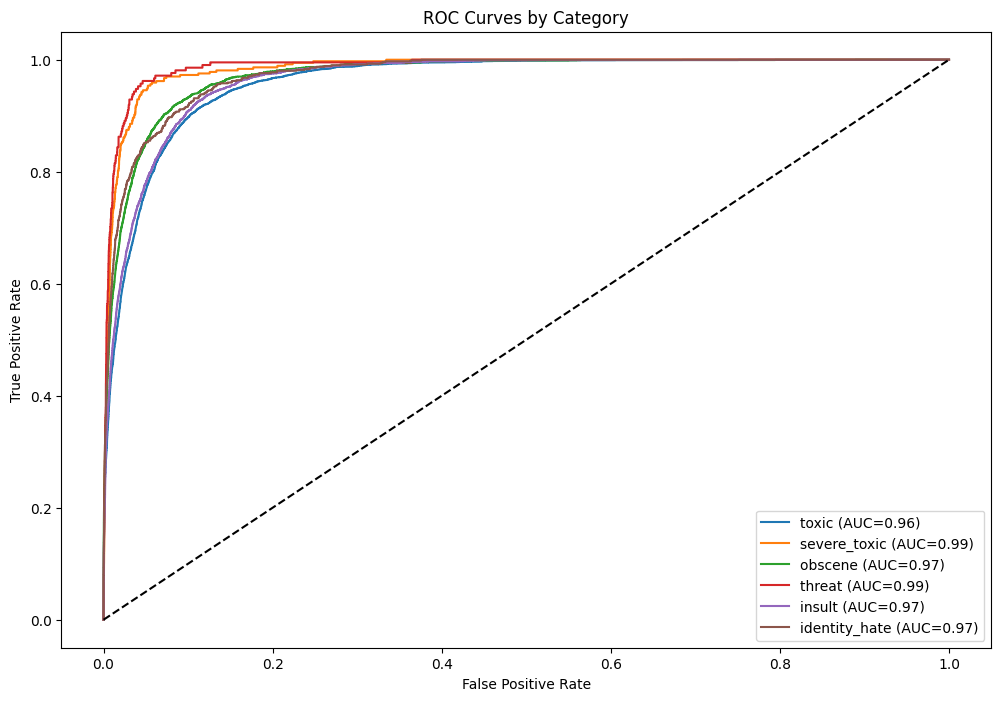


Overall ROC AUC: 0.9745


In [24]:
# evaluate model
metrics = mu.evaluate_model(model, processed_data)

#### -9 Visualize the ROC AUC and loss durning training.

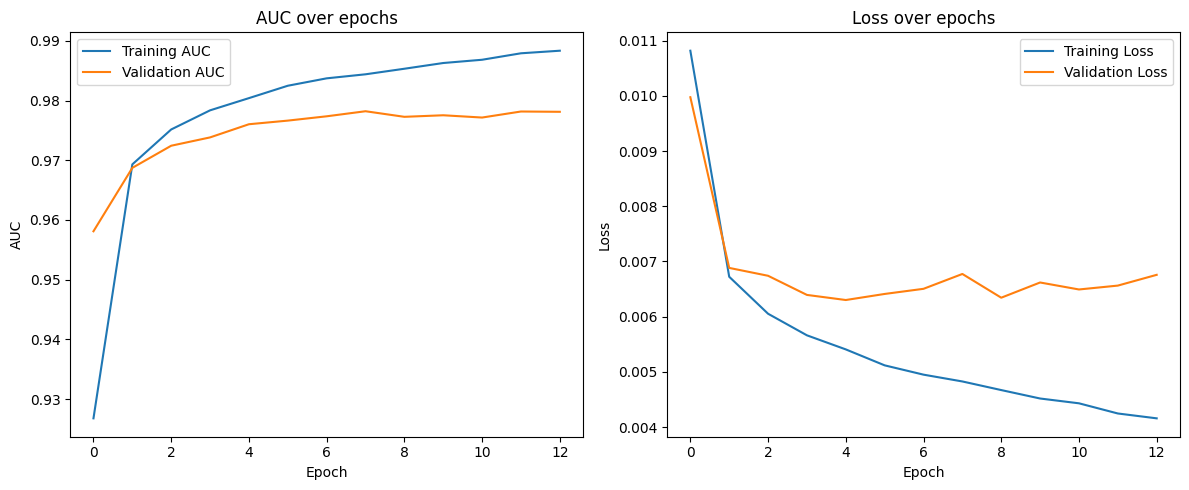

In [25]:
# Visualize results
mu.plot_training_history(history)

### 10- Save the model with tokenizer

In [26]:
# Save model and tokenizer
mu.save_model_and_data(model, processed_data)


Saving model to toxic_model.keras
Saving preprocessing data to preprocessing_data.pkl


### 11- Show Example prediction

In [27]:
# Example prediction
example_comment = "This is a normal comment without any toxic content stupid."

# Clean Text 
cleaned_comment = cleaner.clean_text(example_comment)

# Predict the labels
prediction = mu.predict_toxicity(cleaned_comment, model, processed_data)

print(f"\nExample prediction:")
for category, score in prediction.items():
    print(f"{category}: {score:.4f}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step

Example prediction:
toxic: 0.7700
severe_toxic: 0.2646
obscene: 0.5962
threat: 0.1626
insult: 0.6370
identity_hate: 0.3215


### 12- load and preprocess the test data


In [28]:
# load and preprocess the test data
X_padded, df = mu.load_and_preprocess_test_data(df_test, processed_data['tokenizer'], processed_data['max_seq_length'])

Loading and preprocessing test data...


### 13- Make predictions and submission DF

In [29]:
# Make predictions
y_pred = model.predict(X_padded)

# Create result dictionary
categories = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']
for i, cat in enumerate(categories):
    df[cat] = y_pred[:, i]

sub_df = df[['id', 'toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']]

4787/4787 ━━━━━━━━━━━━━━━━━━━━ 407s 85ms/step


### 14- Save DF to submission.csv file

In [31]:
# Save the submission file
sub_df.to_csv('submission.csv', index=False)

# Wish you all the best 
# Thank You 😊